In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import tinyDA as tda

In [2]:
b = 1
m = 2
x = np.linspace(0,1)
y_pure = b + m*x

sigma = 0.1
y = y_pure + np.random.normal(scale=sigma, size=x.shape[0])

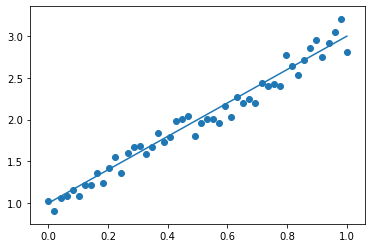

In [3]:
plt.plot(x, y_pure)
plt.scatter(x, y)
plt.show()

In [4]:
mean_prior = np.zeros(2)
cov_prior = np.eye(2)
cov_likelihood = sigma**2*np.eye(x.shape[0])

my_prior = multivariate_normal(mean_prior, cov_prior)
my_loglike_coarse = tda.AdaptiveLogLike(y, cov_likelihood)
my_loglike_fine = tda.LogLike(y, cov_likelihood)

In [5]:
class MyCoarseLinkFactory(tda.LinkFactory):
    def evaluate_model(self, parameters):
        output = parameters[0] + parameters[1]*x + np.random.normal(scale=0.01, size=x.size)
        qoi = None
        return output, qoi

In [6]:
class MyFineLinkFactory(tda.LinkFactory):
    def evaluate_model(self, parameters):
        output = parameters[0] + parameters[1]*x
        qoi = None
        return output, qoi

In [7]:
my_link_factory_coarse = MyCoarseLinkFactory(my_prior, my_loglike_coarse)
my_link_factory_fine = MyFineLinkFactory(my_prior, my_loglike_fine)

In [8]:
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

am_cov = np.eye(2)
am_t0 = 2000
am_sd = 1
am_epsilon = 1e-6
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

In [9]:
my_chain = tda.DAChain(my_link_factory_coarse, my_link_factory_fine, my_proposal, subsampling_rate=10, adaptive_error_model='state-independent')

In [10]:
my_chain.sample(1200)

Running chain, α_c = 1.000, α_f = 1.00:   0%|          | 0/1200 [00:00<?, ?it/s]/home/mikkel/.local/lib/python3.8/site-packages/tinyDA/proposal.py:225: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.posterior - previous_link.posterior)
Running chain, α_c = 0.371, α_f = 0.73: 100%|██████████| 1200/1200 [00:32<00:00, 37.12it/s]


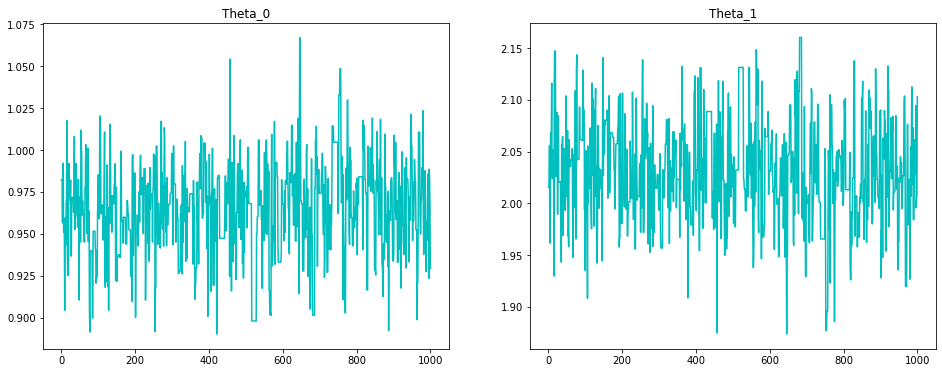

In [11]:
burnin = 200
parameters_fine = tda.get_parameters(my_chain)
tda.plot_parameters(parameters_fine, burnin=burnin)

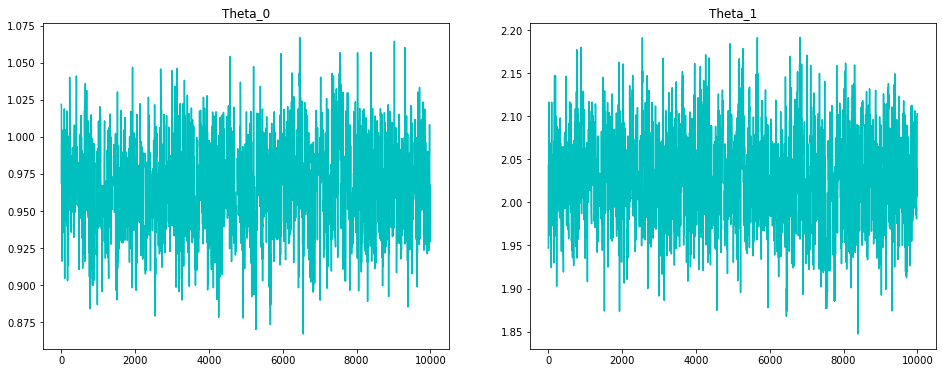

In [12]:
parameters_coarse = tda.get_parameters(my_chain, level='coarse')
tda.plot_parameters(parameters_coarse, burnin=burnin*10)